## Instructions

All work to be done in 1 Jupyter NB.

#### 1. Standard Settings

In [1]:
# standard magic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings('ignore')

#### 2. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg
from sklearn.cluster import KMeans
from numpy import linalg
from sklearn.covariance import OAS, LedoitWolf
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as sch

#### 3. Fix the pseudorandom number generator

In [3]:
np.random.seed(42)

### 1.	Problem 1 (25 points): K-Means and Macro Man on BBG
a.	Import FX spot rates from Currencies_1yr.xls.

b.	Calculate daily return.

c.	Calculate mean return and stdev of return. 

d.	Perform K means using K = 3,4,5,6.

e.	Plot a 2x2 figure with scatter plots with each color representing a cluster and currency label on the scatter plot.  Visualization exercise – your opportunity to play with graphics.

f.	Use elbow method discussed in class plus qualitative argument to recommend # of clusters.  

g.	Discuss cluster traits. 

In [4]:
pd.read_excel('Currencies_1yr.xlsx')

,Dates,USD Curncy,EUR Curncy,GBP Curncy,JPY Curncy,AUD Curncy,NZD Curncy,CAD Curncy,CHF Curncy,NOK Curncy,...,RUB Curncy,CNY Curncy,INR Curncy,TRY Curncy,SGD Curncy,CZK Curncy,DKK Curncy,HRK Curncy,RSD Curncy,AMD Curncy
0,2019-08-14,1,1.1139,1.2060,105.91,0.6748,0.6436,1.3319,0.9732,8.9831,...,66.0525,7.0237,71.2738,5.6123,1.3900,23.2340,6.6969,6.6336,105.7271,475.72
1,2019-08-15,1,1.1107,1.2088,106.12,0.6775,0.6449,1.3313,0.9765,9.0209,...,66.0558,7.0340,71.2738,5.5672,1.3890,23.2636,6.7157,6.6518,105.9878,475.85
2,2019-08-16,1,1.1090,1.2149,106.38,0.6779,0.6429,1.3269,0.9783,9.0053,...,66.5160,7.0428,71.1550,5.5796,1.3845,23.2085,6.7232,6.6618,106.1769,475.90
3,2019-08-19,1,1.1078,1.2126,106.64,0.6764,0.6411,1.3324,0.9817,8.9784,...,66.9160,7.0507,71.4425,5.6603,1.3866,23.2839,6.7316,6.6681,106.2881,476.00
4,2019-08-20,1,1.1100,1.2170,106.23,0.6778,0.6416,1.3319,0.9780,8.9829,...,66.5471,7.0605,71.7100,5.7314,1.3849,23.2332,6.7166,6.6514,106.1138,475.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,2020-09-07,1,1.1817,1.3166,106.27,0.7277,0.6692,1.3098,0.9161,8.9330,...,75.7612,6.8305,73.3475,7.4501,1.3662,22.3999,6.2968,6.3785,99.5967,488.19
279,2020-09-08,1,1.1778,1.2982,106.03,0.7214,0.6619,1.3236,0.9178,9.1305,...,76.2943,6.8464,73.5988,7.4849,1.3708,22.5171,6.3191,6.3982,99.9694,488.66
280,2020-09-09,1,1.1803,1.3002,106.18,0.7283,0.6684,1.3146,0.9124,9.0189,...,75.3250,6.8333,73.5375,7.4879,1.3664,22.4496,6.3037,6.3811,99.6939,488.75
281,2020-09-10,1,1.1815,1.2805,106.13,0.7258,0.6651,1.3192,0.9106,9.0761,...,75.2203,6.8343,73.4587,7.4494,1.3699,22.5110,6.2978,6.3794,99.6110,488.96


In [5]:
# a. Import FX spot rates from Currencies_1y.xls.
currency1 = pd.read_excel('Currencies_1yr.xlsx', index_col='Dates')
currency1.dropna(inplace=True)

In [6]:
# b. Calculate daily return.
currency1_ret = currency1.pct_change(1)
currency1_ret.dropna(inplace=True)

In [7]:
# c. Calculate mean return and stdev of return.
currency1_mean = currency1_ret.mean()
currency1_std = currency1_ret.std(ddof=1)
currency1_stat = pd.concat([currency1_mean, currency1_std], axis=1, keys=['Mean', 'Std'])

In [8]:
# d. Perform K means using K = 3,4,5,6.
def kmeans(x, n_clusters = [3, 4, 5, 6]):
    """
    Input: x (a pandas's DataFrame data structure containing the mean and the standard deviation of different
    countries' currencies); n_clusters (number of clusters used in KMeans' clustering)
    Output: clusters (a list containing the KMeans model and the fitted KMeans' numpy's array)
    Function: Take x and n_clusters, fit KMeans model with each n_cluster in n_clusters, and append KMeans model
    with the fitted KMeans' numpy's array
    """
    clusters = []
    
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster, random_state=42)
        kmeans_fit = kmeans.fit_predict(x)
        clusters.append([kmeans, kmeans_fit])
    
    return clusters  

In [9]:
clusters = kmeans(currency1_stat)
clusters

[[KMeans(n_clusters=3, random_state=42),
  array([1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1],
        dtype=int32)],
 [KMeans(n_clusters=4, random_state=42),
  array([1, 0, 2, 0, 2, 2, 0, 0, 3, 2, 3, 1, 0, 2, 1, 2, 0, 0, 0, 1],
        dtype=int32)],
 [KMeans(n_clusters=5, random_state=42),
  array([4, 0, 2, 0, 2, 2, 0, 0, 3, 2, 3, 1, 1, 2, 1, 2, 0, 0, 0, 1],
        dtype=int32)],
 [KMeans(n_clusters=6, random_state=42),
  array([0, 4, 5, 1, 5, 5, 4, 4, 3, 1, 3, 2, 2, 5, 2, 5, 4, 4, 4, 2],
        dtype=int32)]]

In [10]:
# e. Plot a 2x2 figure with scatter plots with each color representing a cluster and currency label 
# on the scatter plot. Visualization exercise – your opportunity to play with graphics.
def plot(clusters, x = currency1_stat, alpha = 1, dim1 = 15, dim2 = 12, fontsize = 20):
    '''
    Input: clusters (the 2D list output from the previous function "kmeans(...)"); x (default "currency1_stat");
    and a series of default inputs (e.g., alpha = 1 (ttansparency))
    Output: None
    Function: Take the clusters and the transformed dataset KMeans used, visualize the cluster results
    '''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(dim1, dim2), sharey=True) 
    
    for i in range(len(axes)):
        ## Here we use another index "j" to keep track of the indexes of each element iterated through
        ## the object "clusters": So at each axes' index "i", we look at the corresponding "j" indexes
        ## 2*i and 2*i+1 to locate the entries in the object "clusters"
        j = 2*i
        plt.sca(axes[i][0])
        plt.title(r"$k = {}$".format(clusters[j][0].n_clusters), fontsize=fontsize)
        plt.scatter(x['Mean'], x['Std'], marker = 'o', c=clusters[j][1], alpha = alpha)
        ## Plot centroids 
        plt.scatter(clusters[j][0].cluster_centers_[:, 0], clusters[j][0].cluster_centers_[:, 1], 
                    marker = 'x', s=fontsize+80, color = 'r', alpha = alpha)
            
        plt.sca(axes[i][1])
        plt.title(r"$k = {}$".format(clusters[j+1][0].n_clusters), fontsize=fontsize)
        plt.scatter(x['Mean'], x['Std'], marker = 'o', c=clusters[j+1][1], alpha = alpha)
        ## Plot centroids
        plt.scatter(clusters[j+1][0].cluster_centers_[:, 0], clusters[j+1][0].cluster_centers_[:, 1], 
                    marker = 'x', s=fontsize+80, color = 'r', alpha = alpha)
            
    plt.show()
        

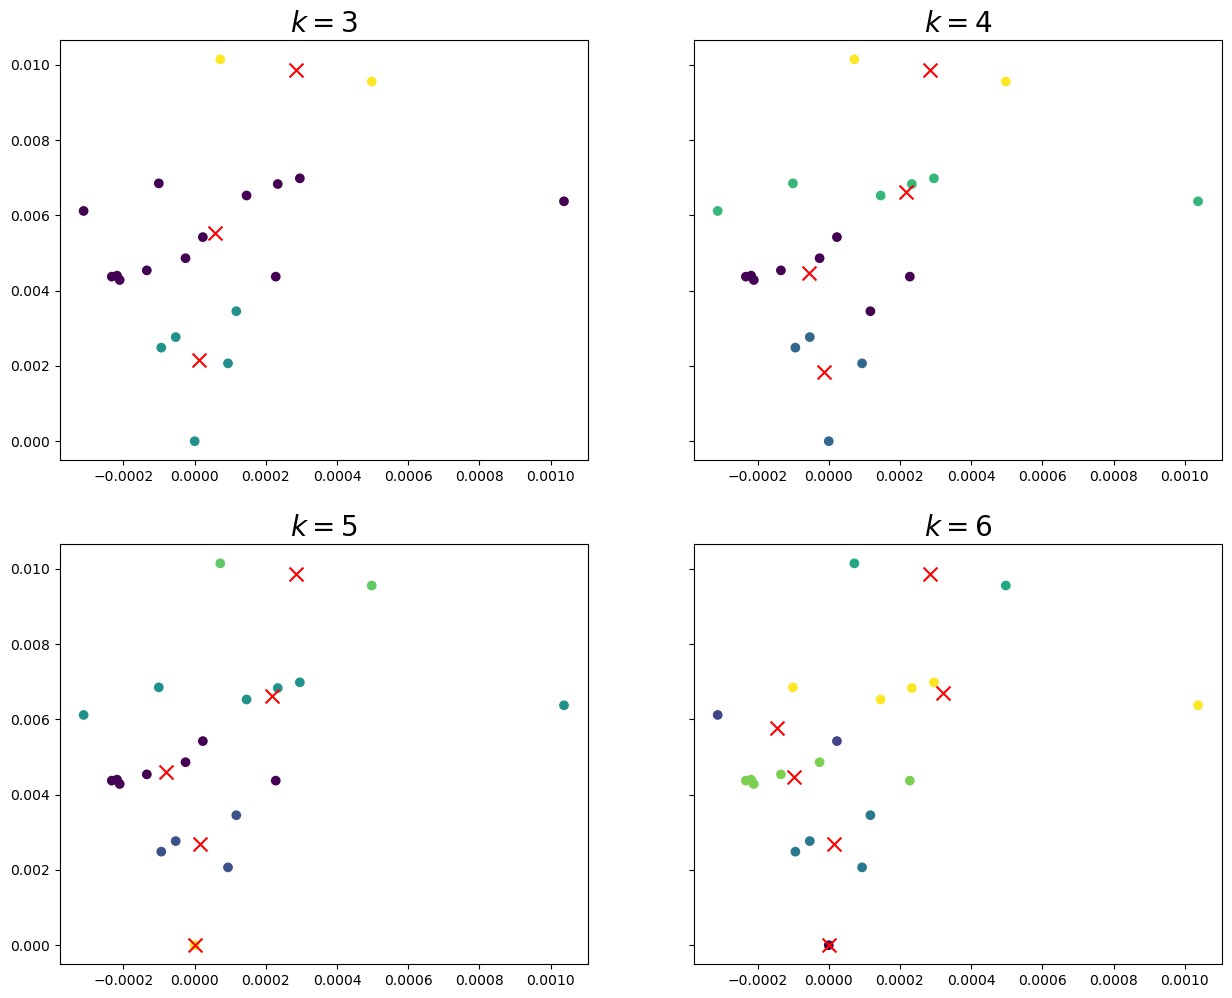

In [11]:
plot(clusters)

Text(0.5, 0, 'Number of clusters: k')

Text(0, 0.5, 'Inertia')

Text(0.45, 0.45, 'Elbow')

(0.0, 22.0, -1e-05, 0.00012)

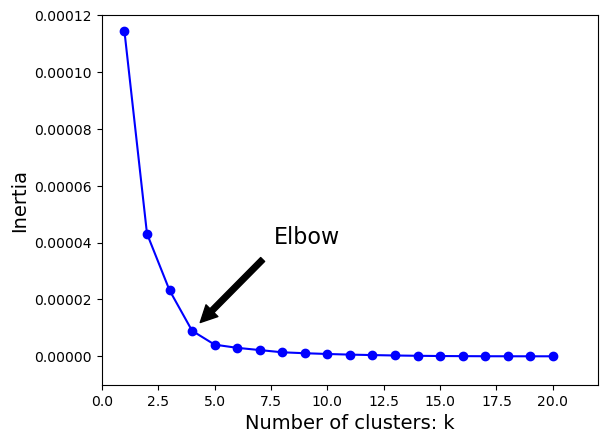

In [12]:
# f. Use elbow method discussed in class plus qualitative argument to recommend # of clusters.
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(currency1_stat) 
                    for k in range(1, len(currency1_stat) + 1)]
inertias = [model.inertia_ for model in kmeans_per_k]
    
plt.plot(range(1, len(currency1_stat) + 1), inertias, 'bo-')
plt.xlabel('Number of clusters: k', fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.45, 0.45),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([0, 22, -0.00001, 0.00012])
plt.show()

As can be seen from the graph, the elbow method suggests either `k=4` or `k=5`. However, according to the 2 by 2 figure from question **e**, `k=4` is favored since when `k=5` it mistakenly assigns a centroid to a point (whose coordinates are (0.000, 0.000)), where in reality it looks more like an outlier rather than a normal datapoint which should be clustered. Therefore, from the combination of the elbow method and the qualitative argument, the optimal number of clusters *k* is recommended to be set at 4.

#### g. Discuss cluster traits.

We discuss the cluster traits based on several criterias based on the upper right subgraph in question **e** (when `k=4`):

**Cluster Size**:
There are some variations of the number of data points assiged to each cluster. However, given that the number of data points assigned to each cluster is not big (i.e., the biggest cluster has only 8 candidates), the KMeans method still have space to learn and improve given more avaliable instances. 

**Centroid**: 
The number of centroid, as a result, cannot have much since the data point has relatively few. In fact, the dataset is spaced relatively sparsely (i.e., less like some dataset which has a clear clusteing structure). So, it makes it relatively difficult to locate the centroids with each cluster. As can be seen (when `k=4`), except for the two clusters having the number of candidates 6 (green) and 8 (purple) respectively, the other two clusters' centroids are placed not at the low density areas (actually the relatively sparese space between two datapoints), making the clustering results less accurate.

**Density**:
As said before, the dataset is spaced relatively sparsely. So, the overall density within each cluster is relatively low, even though some clusters (ones with more instances in it) have a relatively higher density. 

**Variability**:
The degree of variability with each cluster are very different. The purple cluster (when `k=4`) has instances who has a high similarity with each other (i.e., they are relatively more centered around their centroid compared with all of the other clusters). All of the other clusters have at least one outlier (potentially), making the location of centroid be sacrificed to reflect these outliers, hence reducing the similarity of instances within each of them significantly.

**Separation**:
Unfortunatly, there are three clusters located close to each other (i.e., all of the clusters excluding the cluster having the smallest number of instances within it (i.e., the yellow cluster)). This indicates that most clusters are not well separated with each other, thus making it difficult to distinguish between them.

In conclusion, based on the relatively lack of clear clustering structure of the instances, we can see that most criterias suggest the potential improvement of the kmeans' clustering algorithm given more condensed, clear clustering instances.

### 2.	Problem 2 (25 points): Shrinking the covariance matrix

a.	Read http://www.ledoit.net/honey.pdf, https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance.  Write 2 sentences on your understanding of the methodology.

b.	Create a 1000x20 matrix “X” from random normal dist.  Create new matrix X* that is a copy of X.  Replace last two columns with first column with 1e-4 random normal noise added to it.  

c.	Calculate the covariance matrix of X and X* (Sigma, Sigma*) and the corresponding condition number.

d.	Shrink covariace matrix using OAS and Ledoit and Wolf.  Calculate the condition number after shrinkage.

e.	One sentence on the difference between the two.

**a.**
The MLE (maximum likelihood estimation) method for estimating the covariance matrix incurs the issues of inaccurate precision matrices and even singular matrices sometimes. As a result, the shrinkage methods are employed to apply the transformation to the sample covariance matrices by reducing the ratio of the smallest and largest eigenvalues of the sample covariance matrics, thus equaling a simple convex transformation:

$\Sigma_{shrunk} = (1-\alpha)\hat{\Sigma} + \alpha\frac{Tr\hat{\Sigma}}{p}Id$     


In [13]:
# b. Create a 1000x20 matrix “X” from random normal dist. Create new matrix X* that is a copy of X.
# Replace last two columns with first column with 1e-4 random normal noise added to it.
samples = 1000
features = 20
X1 = np.random.randn(samples,features)
X2 = X1.copy()
X2[:,-2:-1] = X1[:,0:1] + np.random.randn(samples,1)*1e-4
X2[:,-1:] = X1[:,0:1] + np.random.randn(samples,1)*1e-4

In [14]:
# c. Calculate the covariance matrix of X and X* (Sigma, Sigma*) and the corresponding condition number.
## Covariance matrix of the number of variables (features) in the given dataset
cov_X1 = np.cov(X1.T)
cov_X2 = np.cov(X2.T)

## Condition Number
cond1 = np.linalg.cond(cov_X1)
cond2 = np.linalg.cond(cov_X2)
print("The condition number for X1 is: {:.4f}".format(cond1))
print("The condition number for X2 is: {:.4f}".format(cond2))

The condition number for X1 is: 1.6352
The condition number for X2 is: 935759086.6811


In [15]:
# d. Shrink covariance matrix using OAS and Ledoit and Wolf. Calculate the condition number after shrinkage.
def condition_after_shrinkage(X):
    '''
    Input: X (the input dataset)
    Output: cond_oas_x &  cond_ledoit_wolf_x (a tuple containing the conditional numbers for each shrinkage
    method, OAS and Ledoit & Wolf)
    Function: Take the original dataset, calculate the each condition number after the OAS's and Ledoit & Wolf's
    covariance shrinkage methods
    '''
    ## Shrink covariance matrix
    cov_oas_x = OAS().fit(X)
    cov_ledoit_wolf_x = LedoitWolf().fit(X)
    
    ## Calculate the conditon number after shrinkage
    cond_oas_x = np.linalg.cond(cov_oas_x.covariance_)
    cond_ledoit_wolf_x = np.linalg.cond(cov_ledoit_wolf_x.covariance_)

    return cond_oas_x, cond_ledoit_wolf_x

In [16]:
cond_oas_x1, cond_ledoit_wolf_x1 = condition_after_shrinkage(X1)
cond_oas_x2, cond_ledoit_wolf_x2 = condition_after_shrinkage(X2)

## Show the results
print("The OAS condition number for X1 is: {:.4f}".format(cond_oas_x1))
print("The Ledoit & Wolf condition number for X1 is: {:.4f}".format(cond_ledoit_wolf_x1))
print("The OAS condition number for X2 is: {:.4f}".format(cond_oas_x2))
print("The Ledoit & Wolf condition number for X2 is: {:.4f}".format(cond_ledoit_wolf_x2))

The OAS condition number for X1 is: 1.0000
The Ledoit & Wolf condition number for X1 is: 1.0000
The OAS condition number for X2 is: 45.8658
The Ledoit & Wolf condition number for X2 is: 45.6359


In [17]:
## Check whether the OAS condition number is equal to the Ledoit & Wolf condition number
cond_oas_x1 == cond_ledoit_wolf_x1

True

**e. One sentence on the difference between the two.**

As can be seen by these 4 new condition numbers and the original two condition numbers shown above, imposing some random normal noises (in this case two random normal noises of the last two given features respectively for each instance) emphasizes the need for using the covariance shrinkage transformation methods (i.e., OAS and Ledoit & Wolf), as there is a huge difference between each of the estimator's and the original condition numbers for the dataset `X2` (i.e., `cond2 = 935759086.6811`, while `cond_oas_x2 = 45.8658`, and `cond_ledoit_wolf_x2=45.6359`), even though both OAS and Ledoit & Wolf methods suggest highly similar results with each other (and even the same outcomes under the non random normal noises' case), hence proving the robustness between these two shrinkage estimators at least.


### 3.	Problem 3 (50 points): Hierarchical Risk Parity: use the price data provided in index_prices.csv.

a.	Calculate Daily Returns

b.	Calculate covariance matrix

c.	Calculate condition number 

d.	Use OAS, calculate condition number

e.	Perform agglomerative clustering

f.	Plot Dendrogram – describe the different clusters.

g.	Get HRP weights using provided functions.


In [18]:
# a. Calculate Daily Returns
df = pd.read_csv('index_prices (1).csv', index_col='Date')
df.dropna(inplace=True)
df_ret = df.pct_change(1)
df_ret.dropna(inplace=True)

In [19]:
# b. Calculate covariance matrix
cov_mat = df_ret.cov().values
corr_mat = df_ret.corr().values

In [20]:
# c. Calculate condition number
print("The condition number is: {:.4f}.".format(np.linalg.cond(cov_mat)))


The condition number is: 6084.0114.


In [21]:
# d. Use OAS, calculate condition number
oas_estimator = OAS().fit(cov_mat)
oas_cond = np.linalg.cond(oas_estimator.covariance_)
print("The OAS condition number is: {:.4f}.".format(oas_cond))


The OAS condition number is: 108.8017.


In [22]:
# e. Perform agglomerative clustering
## Assumptions: assume the number of clusters (k) is 2
ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
ac.fit_predict(df_ret.T)

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>


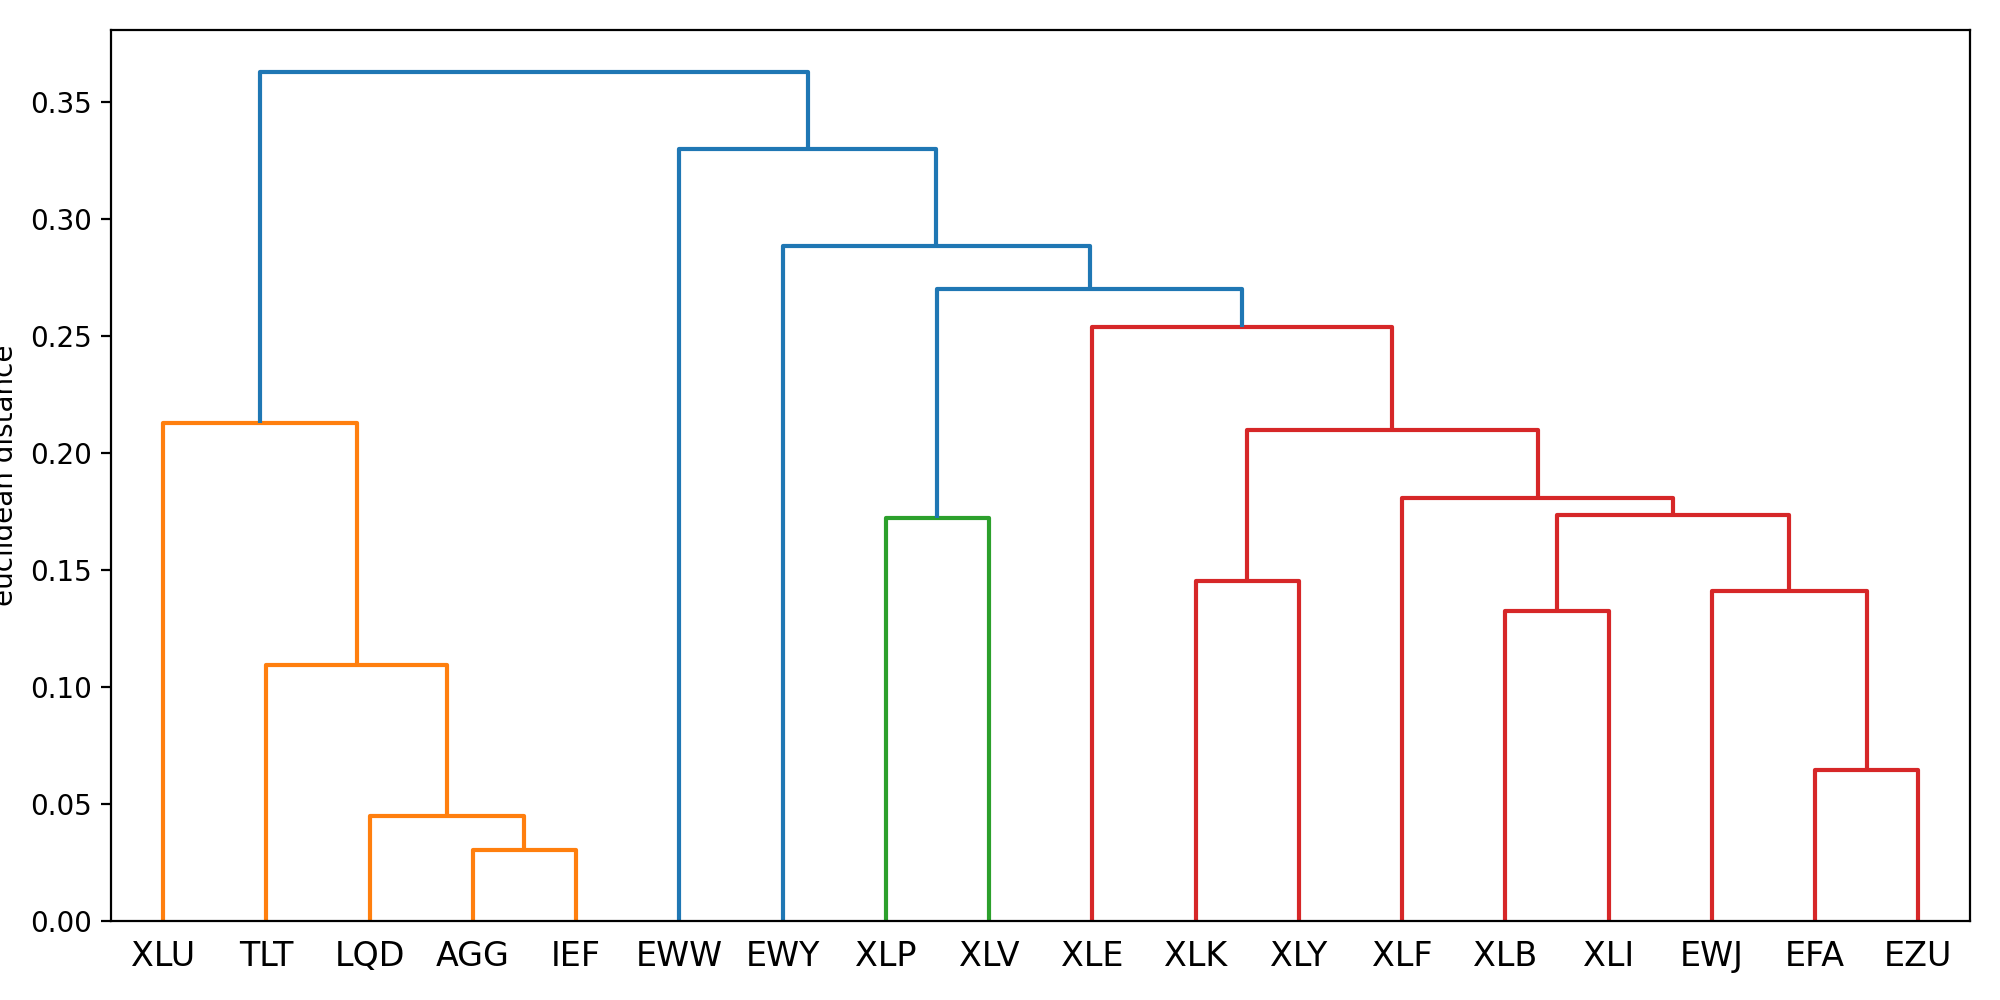

Text(78.72222222222221, 0.5, 'euclidean distance')

In [23]:
# f. Plot Dendrogram – describe the different clusters.
cls=linkage(df_ret.T.values, method='complete', metric='euclidean')

## Plot dendrogram
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,5))
dendr=dendrogram(cls, labels=df_ret.columns, ax=ax)
plt.tight_layout()
plt.ylabel('euclidean distance')

There are two main clusters (the first relatively smaller, while the second relatively bigger) here. The first big cluster are the stock indices "XLU", "TLT", "LQD", "AGG", and "IEF", while the second ones are "EWW", "EWY", "XLP", "XLV", "XLE", "XLK", "XLY", "XLF", "XLB", "XLI", "EWJ", "EFA", and "EZU". Within each big cluster, "XLU" is unlike the rest in cluster 1, and "AGG" and "IEF" are more like to each other than the rest in cluster 1. For cluster 2, there are multiple subclusters within it: the first (relatively small) green subcluster includes "XLP" and "XLV"; the second (relatively bigger) red subcluster contains "XLE", "XLK", "XLY", "XLF", "XLB", "XLI", "EWJ", "EFA", and "EZU". And within the second red subcluster there are even more subclusters (each having a smaller size). In addition, "EWW" and "EWY" are relatively unlike the rest stock indices in the second big cluster.

In [24]:
# g. Get HRP weights using provided functions.
def getIVP(cov):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #dn = sch.dendrogram(link, labels=cov.index.values, label_rotation=90)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

In [25]:
w_ivp = getIVP(cov_mat)
w_hrp = getHRP(df_ret.cov(), df_ret.corr())

In [26]:
np.vstack((w_ivp, w_hrp)).T.shape

(18, 2)

In [27]:
df_results = pd.DataFrame(index = df_ret.columns, data=np.vstack((w_ivp, w_hrp)).transpose())
df_results

,0,1
AGG,0.420972,0.431040
TLT,0.033757,0.010560
IEF,0.173716,0.008848
LQD,0.181784,0.013448
XLB,0.011705,0.007237
XLE,0.008713,0.009033
XLF,0.011368,0.190538
XLI,0.011895,0.186131
XLK,0.008172,0.037026
XLP,0.021054,0.003220


## --- Finished --- ##